In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pylab as plt

In [2]:
# read data from Julien
fname = '/media/ELAsTICC/Fink/first_year/' + \
        'sample_elasticc_training_validation_v1.parquet'

data_julien = pd.read_parquet(fname)

In [3]:
data_julien.shape

(11565, 10)

In [4]:
# get alert ids
alertid_julien = data_julien['alertId'].values

In [5]:
#read training and test
data_train = pd.read_csv('/media/ELAsTICC/Fink/first_year/' + \
                         'early_SNIa/final_model/train.csv', index_col=False)

data_test = pd.read_csv('/media/ELAsTICC/Fink/first_year/' + \
                         'early_SNIa/final_model/test.csv', index_col=False)

In [6]:
# remove alerts that were used for training
flag_train = np.isin(alertid_julien, data_train['alertId'].values)
data_julien = data_julien[~flag_train]
alertid_julien = data_julien['alertId'].values

In [7]:
data_julien.keys()

Index(['alertId', 'classId', 'rf_snia_vs_nonia', 'snn_snia_vs_nonia',
       'snn_broad_class', 'snn_broad_max_prob', 'cats_broad_class',
       'cats_broad_max_prob', 'rf_agn_vs_nonagn', 'rf_slsn_vs_nonslsn'],
      dtype='object')

In [8]:
# read all processed alerts

input_dir = '/media/ELAsTICC/Fink/first_year/early_SNIa/all_features/'

flist = os.listdir(input_dir)
flist.remove('.ipynb_checkpoints')

data_list = []
for fname in flist:
    data_temp = pd.read_csv(input_dir + fname, index_col=False)
    
    col_remove = []
    for colname in data_temp.keys():
        if 'Unnamed' in colname:
            col_remove.append(colname)
            
    if len(col_remove) > 0:
        data_temp.drop(columns=col_remove, inplace=True)

    data_list.append(data_temp)
    
    print(fname, len(data_temp.keys()), data_temp.shape[0], np.unique(data_temp['classId'].values))
    
data_pd = pd.concat(data_list, ignore_index=True)

print('Total: ', data_pd.shape[0])

class_111.csv 48 2507323 [111]
class_131.csv 48 170026 [131]
class_212.csv 48 2230557 [212]
class_214.csv 48 1301841 [214]
class_124.csv 48 12923 [124]
class_123.csv 48 4023 [123]
class_135.csv 48 2761 [135]
class_213.csv 48 429117 [213]
class_221.csv 48 453542 [221]
class_113.csv 48 2451398 [113]
class_115.csv 48 49795 [115]
class_133.csv 48 4043 [133]
class_132.csv 48 30705 [132]
class_121.csv 48 5 [121]
class_134.csv 48 12833 [134]
class_211.csv 48 47713 [211]
class_112.csv 48 583007 [112]
class_114.csv 48 60497 [114]
Total:  10352109


In [9]:
flag_julien = np.isin(data_pd['alertId'].values, alertid_julien)

In [10]:
features_julien = data_pd[flag_julien]

In [11]:
features_julien.shape

(7048, 48)

In [12]:
# read trained model
rf = pickle.load(open('/media/ELAsTICC/Fink/first_year/early_SNIa/' + \
                      'final_model/earlysnia_elasticc_small.pkl', 'rb'))

In [13]:
test_features = features_julien[list(features_julien.keys())[3:]]
test_features.drop(columns=['mwebv_err', 'mwebv_err.1'], inplace=True)

test_labels = features_julien['classId'].values == 111

/media/emille/git/ELAsTiCC/venv/elasticc/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
test_features.keys()

Index(['hostgal_dec', 'hostgal_ra', 'hostgal_snsep', 'hostgal_zphot',
       'hostgal_zphot_err', 'ra', 'decl', 'a_u', 'b_u', 'c_u', 'snratio_u',
       'mse_u', 'nrise_u', 'a_g', 'b_g', 'c_g', 'snratio_g', 'mse_g',
       'nrise_g', 'a_r', 'b_r', 'c_r', 'snratio_r', 'mse_r', 'nrise_r', 'a_i',
       'b_i', 'c_i', 'snratio_i', 'mse_i', 'nrise_i', 'a_z', 'b_z', 'c_z',
       'snratio_z', 'mse_z', 'nrise_z', 'a_Y', 'b_Y', 'c_Y', 'snratio_Y',
       'mse_Y', 'nrise_Y'],
      dtype='object')

In [15]:
pred_labels = rf.predict(test_features)

In [16]:
rf.score(test_features, test_labels)

0.8547105561861521

In [17]:
sum(np.logical_and(pred_labels, test_labels))/sum(pred_labels)

0.6170583115752829

In [18]:
pred_prob = rf.predict_proba(test_features)

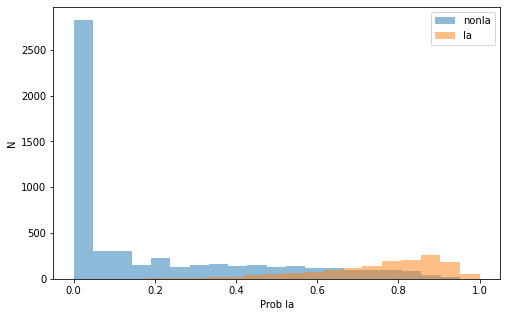

In [19]:
plt.figure(figsize=(8,5))
plt.hist(pred_prob[test_labels == 0][:,1], bins=20, label='nonIa', alpha=0.5)
plt.hist(pred_prob[test_labels == 1][:,1], bins=20, label='Ia', alpha=0.5)
plt.legend()
plt.xlabel('Prob Ia')
plt.ylabel('N')
plt.show()

In [23]:
flag_wrong_ia = np.logical_and(test_labels == 0, pred_labels==1)
contaminants = features_julien[flag_wrong_ia]

cc_ia = features_julien[np.logical_and(test_labels==1, pred_labels==1)]

In [26]:
taxonomy = {111: 'Ia',
           112: 'Ibc',
           113: 'II',
           114: 'Iax',
           115: '91bg',
           120: 'FastOther',
           121: 'KN',
           122: 'Mdwarf',
           123: 'DwarfNovae',
           124: 'mLens',
           130: 'LongOther',
           131: 'SLSN',
           132: 'TDE',
           133: 'ILOT',
           134: 'CART',
           135: 'PISN',
           210: 'PeriodicOther',
           211: 'Cepheid',
           212: 'RRLyrae',
           213: 'dScuti',
           214: 'EB',
           215: 'LPVMira',
           220: 'NonPeriodicOther',
           221: 'AGN'}

bands = ['u', 'g', 'r', 'i', 'z', 'Y']

In [53]:
obj_class, freq = np.unique(contaminants['classId'].values, return_counts=True)

for i in range(len(freq)):
    print(taxonomy[obj_class[i]], round(freq[i]/contaminants.shape[0],2))

Ibc 0.21
II 0.7
Iax 0.02
91bg 0.02
SLSN 0.01
TDE 0.01
CART 0.0
RRLyrae 0.0
EB 0.0
AGN 0.01


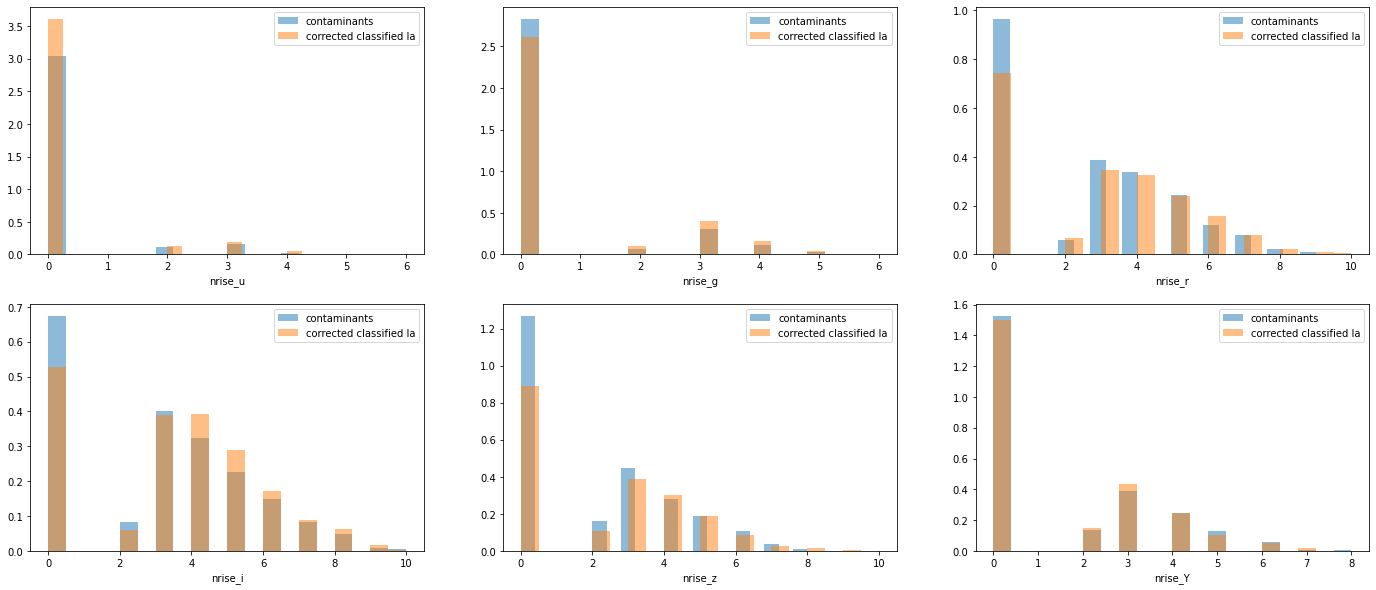

In [27]:
plt.figure(figsize=(24,10))

for i in range(len(bands)):
    plt.subplot(2,3,i+1)
    plt.hist(contaminants['nrise_' + bands[i]], bins=20, label='contaminants', 
              alpha=0.5, density=True) 
    plt.hist(cc_ia['nrise_' + bands[i]], bins=20, label='corrected classified Ia', 
             alpha=0.5, density=True)
    plt.legend()
    plt.xlabel('nrise_' + bands[i])
    
plt.show()

In [31]:
np.argsort(rf.feature_importances_)

array([12, 11, 18,  7,  8, 17, 42, 13, 14,  9, 36, 41, 24, 15, 10, 37, 35,
       38, 16, 30, 31, 39, 33, 32,  6, 29, 34, 23,  5, 28, 22, 20, 40, 19,
       25, 27, 21, 26,  2,  1,  0,  4,  3])